In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.optimize import fsolve

In [2]:
## parameters, UD=underdamped, OD=overdamped
N   = 10960            # # of data points
m   = 1                # mass
T   = 1                # temperature
k   = 1                # stiffness
k_B = 1                # Boltzmann constant
f_s = 1                # sampling frequency
dt  = 1/f_s            # step size
g_c = np.sqrt(4*m*k)   # critical gamma
g_f = .5               # <1 for UD and >1 for OD
g   = g_c*g_f          # gamma
w0  = np.sqrt(k/m)     # frequency of UD motion
tau = m/g              # relaxation time
D   = k_B*T/g          # diffusion constant

if g_f >1:
    w = 1j*np.sqrt(-(w0**2)+(1/(4*tau*tau))) 
else:
    w = np.sqrt((w0**2)-(1/(4*tau*tau)))

simparams = (N, dt, w, w0, tau)

In [3]:
def sigmamatrix(simparams):
    N, dt, w, w0, tau = simparams
    tt   = 2*w*dt;  w02  = w0*w0;  w2 = w*w
    tau2 = tau*tau; tau3 = tau2*tau; dtbt=-dt/tau
    wt2=w2*tau2; dd=D/(wt2); dd1=dd/(4*w02*tau); dd2=dd/(4*tau)

    ss1 = np.cos(tt) - (2*w*tau*np.sin(tt)) - (4*w02*tau2)
    ss2 = np.cos(tt) + (2*w*tau*np.sin(tt)) - (4*w02*tau2)

    sigma2_xx = dd1*(4*w2*tau2 + np.exp(dtbt)*ss1)
    sigma2_vv = dd2*(4*w2*tau2 + np.exp(dtbt)*ss2)
    sigma2_xv = dd*np.exp(dtbt)*np.sin(w*dt)*np.sin(w*dt)
    return np.real(sigma2_xx), np.real(sigma2_vv), np.real(sigma2_xv)    
sigma_matrix = sigmamatrix(simparams)

def explambda(simparams):
    N, dt, w, w0, tau = simparams
    I = np.eye(2)
    J11 =(1/(2*w*tau))
    J12 = (1/w)
    J21 = -(w0**2)/w
    J22 = -J11
    J = np.matrix([[J11,J12],[J21,J22]])
    return np.real(np.exp(-dt/(2*tau))*((np.cos(w*dt)*I)+(np.sin(w*dt)*J)))
expM = explambda(simparams)

In [4]:
def simxv(simparams, sigma_matrix, expM):
    N, dt, w, w0, tau = simparams
    x = np.zeros([N,1])
    v = np.zeros([N,1])
    
    sigma2_xx, sigma2_vv, sigma2_xv = sigma_matrix

    for j in np.arange(0,N-1):
        oldvec = np.array([x[j],v[j]])
        randgauss = np.random.randn(2,1)
        delx = np.sqrt(sigma2_xx)*randgauss[0]
        delv = (sigma2_xv/(np.sqrt(sigma2_xx)))*randgauss[0]+(np.sqrt(sigma2_vv - ((sigma2_xv**2)/(sigma2_xx))))*randgauss[1]
        delvec = np.array([delx,delv])
        updatevec = np.dot(expM,oldvec)+delvec
        x[j+1] = updatevec[0]
        v[j+1] = updatevec[1]
    return x,v


In [5]:
simparams = (N, dt, w, w0, tau)
sigma_matrix = sigmamatrix(simparams)
expM = explambda(simparams)
x, v = simxv(simparams, sigma_matrix, expM)

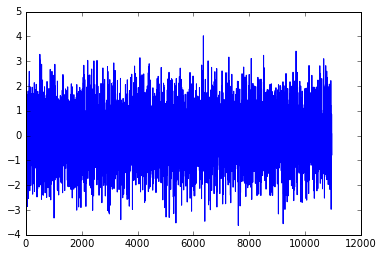

In [6]:
plt.plot(x);

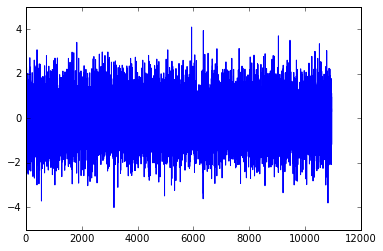

In [7]:
plt.plot(v);

In [8]:
#matrix sufficient statistics
T1_11 = np.sum(x[1:]**2)
T1_12 = np.sum(x[1:]*v[1:])
T1_21 = T1_12
T1_22 = np.sum(v[1:]**2)

T2_11 = np.sum(x[1:]*x[:-1])
T2_12 = np.sum(x[1:]*v[:-1])
T2_21 = np.sum(v[1:]*x[:-1])
T2_22 = np.sum(v[1:]*v[:-1])

T3_11 = np.sum(x[:-1]*x[:-1])
T3_12 = np.sum(x[:-1]*v[:-1])
T3_21 = T3_12
T3_22 = np.sum(v[:-1]*v[:-1])


T1 = np.asanyarray([[T1_11,T1_12],[T1_21,T1_22]])
T2 = np.asanyarray([[T2_11,T2_12],[T2_21,T2_22]])
T3 = np.asanyarray([[T3_11,T3_12],[T3_21,T3_22]])
T2

array([[ 7234.87217393,  5758.5722871 ],
       [-5767.56311738,  1365.67950512]])

In [9]:
#MAP estimate of Sigma matrix
invT3 = np.linalg.inv(T3)

Sigma_est = (1/N)*(T1 - np.dot(T2, np.dot( invT3, T2.transpose())))
print Sigma_est 

[[ 0.27739856  0.2799366 ]
 [ 0.2799366   0.69434747]]


In [10]:
#MAP estimate of Sigma matrix

invT3 = np.linalg.inv(T3)
Sigma_est = (1/N)*(T1 - np.dot(T2, np.dot( invT3, T2.transpose())))
#print Sigma_est 

In [11]:
#MAP estimate of Lambda matrix
Lambda_exp =Lambda_exp = np.dot( T2, invT3)
np.dot( T2, invT3)
#print Lambda_exp

array([[ 0.66410477,  0.53408943],
       [-0.52776194,  0.12458279]])

In [17]:
#MAP estimate of k and m and gamma

coeffmat = np.matrix([[1-(Lambda_exp[0,0]**2),-Lambda_exp[0,1]**2],[-Lambda_exp[1,0]**2,1-(Lambda_exp[1,1]**2)]])
invcoeffmat = np.linalg.inv(coeffmat) # inverse of RHS Matrix
sigvec = np.array([Sigma_est[0,0],Sigma_est[1,1]]) #RHS vector
cvec = np.dot(invcoeffmat,sigvec) #LHS vector (solution)

#The solution vector is [k_B*T/k, k_B*T/m]

k_est_inv = (k_B*T)/cvec[0,0] 
m_est_inv = (k_B*T)/cvec[0,1]
gamma_est_inv = (Sigma_est[0,1]*(m_est_inv**2))/(k_B*T*(Lambda_exp[0,1]**2))

print k_est_inv
print m_est_inv
print gamma_est_inv 

0.999322094316
1.01172583558
1.00451721921


In [14]:
#Print c matrix obtained from result in appendix
print np.matrix([[cvec[0,0],0],[0,cvec[0,1]]]) 

[[ 1.00067837  0.        ]
 [ 0.          0.98841007]]


In [18]:
#using Onsages Casimir symmetry
Lambda_exp2 = np.dot(Lambda_exp, Lambda_exp)
Lambda_exp2 = Lambda_exp2.transpose()
epsilon = np.asanyarray([[1,0],[0,-1]])
Eeps = np.dot( Lambda_exp2, epsilon)
c_Onsager =(np.eye(2) - np.dot(epsilon, Eeps))
c_Onsager = np.dot(c_Onsager, Sigma_est)

print c_Onsager

[[ 0.11672635 -0.05363366]
 [ 0.47134656  0.99720536]]
